<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
XGBoost for Regression 
</p>

In [23]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.model_selection import (              # For cross-validation, splitting data, and grid search
    KFold, 
    train_test_split,
    ParameterGrid,
    GridSearchCV
)
from sklearn.metrics import (                     # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

# XGBoost library
import xgboost as xgb                             # For XGBoost Regressor

# ================================
# Set Seed for Reproducibility
# ================================
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

In [24]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()
print("\nFirst Five Rows of the Dataset:")
display(df.head())


Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749214 entries, 0 to 749213
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         749214 non-null  object 
 1   device_id    749214 non-null  object 
 2   co2          749214 non-null  float64
 3   humidity     749214 non-null  float64
 4   pm25         749214 non-null  float64
 5   pressure     749214 non-null  float64
 6   temperature  749214 non-null  float64
 7   rssi         749214 non-null  float64
 8   snr          749214 non-null  float64
 9   SF           749214 non-null  int64  
 10  frequency    749214 non-null  float64
 11  f_count      749214 non-null  float64
 12  p_count      749214 non-null  float64
 13  toa          749214 non-null  float64
 14  distance     749214 non-null  int64  
 15  c_walls      749214 non-null  int64  
 16  w_walls      749214 non-null  int64  
 17  exp_pl       749

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:00:52.542462+00:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.4,-86.737602,-74.237602
2,2024-09-26 11:02:52.425491+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
3,2024-09-26 11:02:52.426016+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
4,2024-09-26 11:03:52.481201+00:00,ED3,645.0,54.25,0.33,300.50,23.90,-76.0,13.2,9,868.3,97.0,107.0,0.246784,18,1,2,93.4,-89.403045,-76.203045


In [25]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=RANDOM_STATE
)

print("Train-test split completed.")


Train-test split completed.


In [ ]:
# Define max_depth values and an expanded parameter grid
max_depth_values = [1, 2, 3]
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

best_models = {}
best_params_per_depth = {}
best_scores_per_depth = {}

# Pre-create the DMatrix to avoid repeated computation
dtrain = xgb.DMatrix(X_train_all, label=PL_train_all)

for depth in max_depth_values:
    print(f"\nPerforming Grid Search for max_depth={depth}...")
    best_mse = float('inf')
    best_params = None
    best_num_boost_round = 0

    # Iterate over all combinations in the parameter grid
    for params in ParameterGrid(param_grid):
        # Extract and remove 'n_estimators' from params
        n_estimators = params.pop('n_estimators')

        # Add parameters specific to the current max_depth
        params.update({
            'max_depth': depth,
            'objective': 'reg:squarederror',
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        })

        # Perform cross-validation with num_boost_round set to n_estimators
        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=n_estimators,  # Set num_boost_round to n_estimators
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            seed=RANDOM_STATE,
            verbose_eval=False
        )

        # Extract the best RMSE and corresponding number of boosting rounds
        mean_rmse = cv_results['test-rmse-mean'].min()
        mse = mean_rmse ** 2
        best_round = cv_results['test-rmse-mean'].idxmin() + 1  # +1 because indexing starts at 0

        if mse < best_mse:
            best_mse = mse
            best_params = params.copy()
            best_params['num_boost_round'] = best_round  # Update num_boost_round based on CV

    # Extract 'num_boost_round' from best_params and remove it
    num_boost_round = best_params.pop('num_boost_round')

    # Train the final model with the best parameters
    final_model = xgb.train(best_params, dtrain, num_boost_round=num_boost_round)

    # Store the best model and its parameters
    best_models[depth] = final_model
    best_params_per_depth[depth] = best_params
    best_scores_per_depth[depth] = best_mse

    print(f"Best Parameters for max_depth={depth}: {best_params}")
    print(f"Best CV MSE for max_depth={depth}: {best_mse:.4f}")



Performing Grid Search for max_depth=1...


In [ ]:
# Initialize a list to store evaluation metrics for each model
evaluation_metrics = []

for depth in max_depth_values:
    model = best_models[depth]
    params = best_params_per_depth[depth]
    
    print(f"\nEvaluating model with max_depth={depth} and parameters: {params}")
    
    # Make predictions on the training set
    PL_train_pred = model.predict(xgb.DMatrix(X_train_all))
    # Make predictions on the test set
    PL_test_pred = model.predict(xgb.DMatrix(X_test_all))
    
    # Calculate metrics
    train_mse = mean_squared_error(PL_train_all, PL_train_pred)
    test_mse = mean_squared_error(PL_test_all, PL_test_pred)
    train_r2 = r2_score(PL_train_all, PL_train_pred)
    test_r2 = r2_score(PL_test_all, PL_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
    test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)
    
    # Append metrics to the list
    evaluation_metrics.append({
        'max_depth': depth,
        'Training Loss (MSE)': train_mse,
        'Test Loss (MSE)': test_mse,
        'Test RMSE': test_rmse,
        'R² Score': test_r2,
        'Test MAPE (%)': test_mape * 100,
        'Test Median AE': test_median_ae
    })
    
    print(f"Model with max_depth={depth} - Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAPE: {test_mape*100:.2f}%, Test Median AE: {test_median_ae:.4f}")

# Create a results DataFrame
results_df = pd.DataFrame(evaluation_metrics)

print("\nModel Evaluation Metrics for Best Models per max_depth:")
display(results_df)



Evaluating model with max_depth=1 and parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'max_depth': 1, 'objective': 'reg:squarederror', 'random_state': 50, 'n_jobs': -1}
Model with max_depth=1 - Training MSE: 39.0179, Test MSE: 38.7585
Training R²: 0.8902, Test R²: 0.8910
Test RMSE: 6.2256, Test MAPE: 4.86%, Test Median AE: 3.3653

Evaluating model with max_depth=2 and parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'min_child_weight': 3, 'subsample': 0.8, 'max_depth': 2, 'objective': 'reg:squarederror', 'random_state': 50, 'n_jobs': -1}
Model with max_depth=2 - Training MSE: 23.4150, Test MSE: 23.2087
Training R²: 0.9341, Test R²: 0.9347
Test RMSE: 4.8175, Test MAPE: 3.96%, Test Median AE: 2.6917

Evaluating model with max_depth=3 and parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'max_depth': 3, 'objective': 'reg:squarederror', 'ra

,max_depth,Training Loss (MSE),Test Loss (MSE),Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,1,39.017865,38.758460,6.225629,0.890989,4.864346,3.365251
1,2,23.414993,23.208709,4.817542,0.934724,3.956835,2.691679
2,3,19.803362,19.708600,4.439437,0.944568,3.605990,2.421938


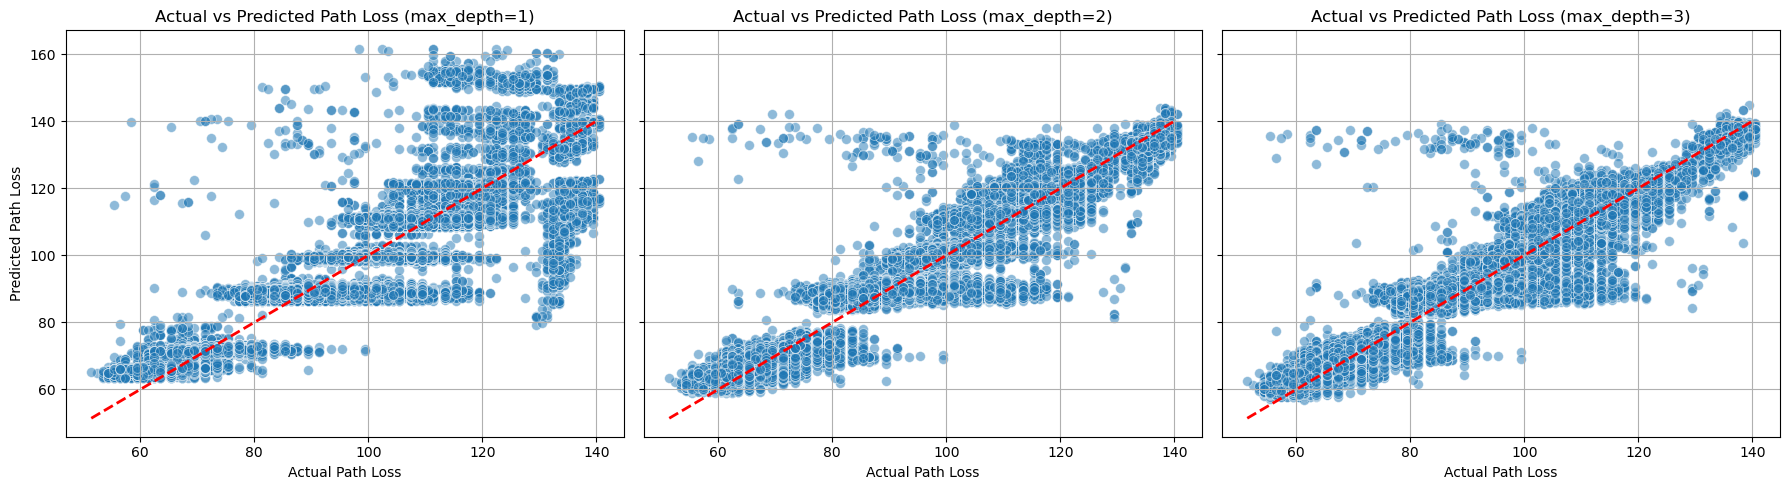

In [ ]:
# Number of models
num_models = len(max_depth_values)

# Set up the subplot grid (1 row, 3 columns)
fig, axes = plt.subplots(1, num_models, figsize=(18, 5), sharey=True)

# If only one subplot, make axes iterable
if num_models == 1:
    axes = [axes]

for ax, depth in zip(axes, max_depth_values):
    model = best_models[depth]
    # Make predictions using DMatrix
    PL_test_pred = model.predict(xgb.DMatrix(X_test_all))
    
    sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.5, edgecolor='w', s=50, ax=ax)
    ax.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Path Loss')
    ax.set_ylabel('Predicted Path Loss')
    ax.set_title(f'Actual vs Predicted Path Loss (max_depth={depth})')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# ================================
# Cross-Validation on Best Models
# ================================

# Define the number of folds for cross-validation
n_folds = 5

# Initialize KFold with consistent RANDOM_STATE
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Dictionary to store cross-validation results
cv_results_dict = {depth: [] for depth in max_depth_values}

print("\nPerforming K-Fold Cross-Validation for Each Best Model...\n")

for depth in max_depth_values:
    params = best_params_per_depth[depth]
    
    print(f"Cross-Validation for max_depth={depth} with parameters: {params}")
    
    # Instantiate the XGBRegressor with best parameters
    xgb_cv = xgb.XGBRegressor(
        max_depth=depth,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        gamma=params['gamma'],
        objective='reg:squarederror',
        random_state=RANDOM_STATE, 
        n_jobs=-1
    )
    
    # Perform cross-validation using cross_val_score
    # Using neg_mean_squared_error to get MSE
    mse_scores = -cross_val_score(
        xgb_cv, 
        X_train_all, 
        PL_train_all, 
        cv=kf, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Calculate additional metrics manually for each fold
    # Since cross_val_score only provides MSE, we'll perform manual CV to get other metrics
    fold = 1
    for train_idx, val_idx in kf.split(X_train_all):
        # Split the data for the current fold
        X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
        PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]
        
        # Train the model on the current fold
        xgb_cv.fit(X_train_fold, PL_train_fold)
        
        # Predict on validation set
        PL_val_pred = xgb_cv.predict(X_val_fold)
        
        # Calculate metrics
        val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(PL_val_fold, PL_val_pred)
        val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
        val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)
        
        # Append metrics to the dictionary
        cv_results_dict[depth].append({
            'Fold': fold,
            'Validation Loss (MSE)': round(val_mse, 4),
            'Validation RMSE': round(val_rmse, 4),
            'R² Score': round(val_r2, 4),
            'Validation MAPE (%)': round(val_mape * 100, 2),
            'Validation Median AE': round(val_median_ae, 4)
        })
        
        print(f"  Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}")
        fold += 1

# ================================
# Display Cross-Validation Results
# ================================
for depth in max_depth_values:
    print(f"\nK-Fold Cross-Validation Results for max_depth={depth}:")
    cv_results_df = pd.DataFrame(cv_results_dict[depth])
    display(cv_results_df)
    
    # Summary statistics
    cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
    cv_summary.rename(columns={'index': 'Metric'}, inplace=True)
    print(f"\nCross-Validation Summary for max_depth={depth}:")
    display(cv_summary)
    
    # Visualization: Boxplots of Metrics
    metrics_to_plot = ['Validation Loss (MSE)', 'Validation RMSE', 'R² Score', 'Validation MAPE (%)', 'Validation Median AE']
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=cv_results_df[metrics_to_plot])
    plt.title(f'Cross-Validation Metrics for max_depth={depth}')
    plt.ylabel('Metric Values')
    plt.show()



Performing K-Fold Cross-Validation for Each Best Model...

Cross-Validation for max_depth=1 with parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'max_depth': 1, 'objective': 'reg:squarederror', 'random_state': 50, 'n_jobs': -1}


KeyError: 'n_estimators'